## Keras Callbacks

This is to show implementations of Keras Callbacks and how to use them

- 1 Basic History and plotting  
- 2 TensorBoard implementation  
- 3 Model checkpoints  
- 4 Early Stopping  
- 5 Learning Rate Scheduler  
- 6 ReduceLROnPlateau  
- 7 LambdaCallback 

### Set up a model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.callbacks import LambdaCallback
from keras import backend as K

import tensorflow as tf



Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.5
1.2.1


In [3]:
batch_size = 128
num_classes = 10
epochs = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11321344/11490434 [============================>.] - ETA: 0s60000 train samples
10000 test samples


In [4]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,),name='Dense1'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu',name='Dense2'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

### Basic History and ploting

In [7]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
5s - loss: 0.2454 - acc: 0.9251 - val_loss: 0.1043 - val_acc: 0.9686
Epoch 2/10
4s - loss: 0.1014 - acc: 0.9685 - val_loss: 0.0855 - val_acc: 0.9752
Epoch 3/10
4s - loss: 0.0755 - acc: 0.9778 - val_loss: 0.0772 - val_acc: 0.9785
Epoch 4/10
4s - loss: 0.0623 - acc: 0.9815 - val_loss: 0.0799 - val_acc: 0.9797
Epoch 5/10
4s - loss: 0.0517 - acc: 0.9847 - val_loss: 0.0804 - val_acc: 0.9803
Epoch 6/10
4s - loss: 0.0452 - acc: 0.9870 - val_loss: 0.0885 - val_acc: 0.9791
Epoch 7/10
4s - loss: 0.0397 - acc: 0.9882 - val_loss: 0.0734 - val_acc: 0.9829
Epoch 8/10
4s - loss: 0.0353 - acc: 0.9902 - val_loss: 0.0905 - val_acc: 0.9793
Epoch 9/10
5s - loss: 0.0323 - acc: 0.9907 - val_loss: 0.0851 - val_acc: 0.9824
Epoch 10/10
4s - loss: 0.0316 - acc: 0.9910 - val_loss: 0.1063 - val_acc: 0.9791
Test loss: 0.106284460687
Test accuracy: 0.9791


In [8]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

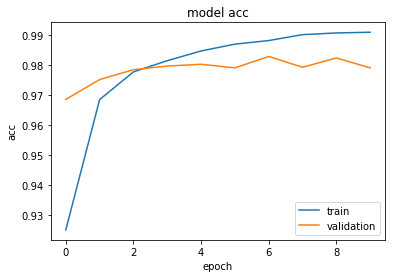

In [9]:
plot_train(history)

### Model Checkpoints

args 
- filepath - str  can use formating to put epoch number etc {epoc}
- monitor - qunatity to monitor  
- verbose - 0 or 1  
- save_best_only - only save if better than before  
- mode - use 'auto'  
- save_weights_only - if false then will save whole model
- period - the interval between epochs  

In [10]:
checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

In [12]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint])

Epoch 00000: val_loss did not improve
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.09254 to 0.09184, saving model to ./checkpoints/weights_02_0.98.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve


### TensorBoard Callback

args
- log_dir : string , must exist
- histogram_freq : freq in epochs
- write_graph : true or false for seeing the graph in TB  
- write_grads :writing the gradients  not working 2.04
- batch_size : size of batches for histogram  
- write_images :whether to write model weights to see  
- embeddings_freq : 
- embeddings_layer_names :
- embeddings_metadata :

In [13]:
TB = TensorBoard(log_dir='./logs', histogram_freq=1,
                            write_graph=True,  write_images=False)
#tf.reset_default_graph()

In [14]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                    callbacks=[TB])

INFO:tensorflow:Summary name Dense1/kernel:0 is illegal; using Dense1/kernel_0 instead.
INFO:tensorflow:Summary name Dense1/bias:0 is illegal; using Dense1/bias_0 instead.
INFO:tensorflow:Summary name Dense2/kernel:0 is illegal; using Dense2/kernel_0 instead.
INFO:tensorflow:Summary name Dense2/bias:0 is illegal; using Dense2/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


In [15]:
!tensorboard --logdir=logs

Starting TensorBoard b'54' at http://Sams-MacBook-Pro.local:6006
(Press CTRL+C to quit)
^C


### Early Stopping - stop training when a monitored quanity has stopped improving
args
- monitor : what to monitor 'val_loss', 'acc'
- min_delta :minimum change to qualify as improvement
- patience : number of epocs with no improvement before you stop
- verbose : verbosity mode
- mode : 'auto' , can be 'min' or 'max' determines direction of improvement. Auto = based on monitor

In [16]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto')

In [17]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.0137 - acc: 0.9968 - val_loss: 0.1277 - val_acc: 0.9835
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.0160 - acc: 0.9963 - val_loss: 0.1229 - val_acc: 0.9846
Epoch 3/10
60000/60000 [==============================] - 5s - loss: 0.0155 - acc: 0.9969 - val_loss: 0.1248 - val_acc: 0.9838


above stopped after 3 epochs instead of 10 as validation loss didn't get better

### Learning Rate Scheduler
arg
- schedule - this will be function that takes epoch number(int) and returns new Learning Rate (float) 

#### LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)

In [18]:
import math

# learning rate schedule for dropping every 10 epochs
def LRDropping(epoch):
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [23]:
LRDropping(2)

0.0009000000000000001

In [24]:
LRDrop = LearningRateScheduler(LRDropping)

In [25]:
K.set_value(model.optimizer.lr,0.001)

In [26]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[LRDrop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.0122 - acc: 0.9971 - val_loss: 0.1223 - val_acc: 0.9848
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.0134 - acc: 0.9972 - val_loss: 0.1182 - val_acc: 0.9845
Epoch 3/10
60000/60000 [==============================] - 4s - loss: 0.0099 - acc: 0.9977 - val_loss: 0.1194 - val_acc: 0.9847
Epoch 4/10
60000/60000 [==============================] - 4s - loss: 0.0131 - acc: 0.9974 - val_loss: 0.1291 - val_acc: 0.9836
Epoch 5/10
60000/60000 [==============================] - 4s - loss: 0.0095 - acc: 0.9978 - val_loss: 0.1212 - val_acc: 0.9854
Epoch 6/10
60000/60000 [==============================] - 4s - loss: 0.0085 - acc: 0.9980 - val_loss: 0.1331 - val_acc: 0.9835
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.0091 - acc: 0.9981 - val_loss: 0.1469 - val_acc: 0.9845
Epoch 8/10
60000/60000 [==============================] - 5s 

In [27]:
#print out the learning rate
print(K.eval(model.optimizer.lr))

0.000729


### ReduceLROnPlateau
args
- monitor : quality to be monitored eg. 'val_loss' , 'val_acc'
- factor : the factor by which the current LR be multiplied  
- patience : number of epochs with no improvement  
- verbose : 1 = update messages 0 nothing
- mode : 'auto'  eg. is improvment up or down 'min' 'max'
- epsilon : threshold for measuring the new optimum, to only focus on significant changes  
- cooldown :number of epochs to wait before any new changes
- min_lr: the lowest lr allowed 

In [28]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.9, patience=3,cooldown=2, min_lr = 0.00001)

In [29]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_LR])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.0066 - acc: 0.9987 - val_loss: 0.1240 - val_acc: 0.9858
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.0062 - acc: 0.9987 - val_loss: 0.1491 - val_acc: 0.9839
Epoch 3/10
60000/60000 [==============================] - 4s - loss: 0.0077 - acc: 0.9986 - val_loss: 0.1414 - val_acc: 0.9861
Epoch 4/10
60000/60000 [==============================] - 5s - loss: 0.0078 - acc: 0.9986 - val_loss: 0.1402 - val_acc: 0.9853
Epoch 5/10
60000/60000 [==============================] - 5s - loss: 0.0062 - acc: 0.9986 - val_loss: 0.1438 - val_acc: 0.9856
Epoch 6/10
60000/60000 [==============================] - 5s - loss: 0.0064 - acc: 0.9987 - val_loss: 0.1358 - val_acc: 0.9855
Epoch 7/10
60000/60000 [==============================] - 5s - loss: 0.0055 - acc: 0.9989 - val_loss: 0.1328 - val_acc: 0.9857
Epoch 8/10
60000/60000 [==============================] - 5s 

In [30]:
#print out the learning rate
print(K.eval(model.optimizer.lr))

0.00059049


### LambdaCallback a way to call anon functions in the callback
args
- on_epoch_being - called at begin of epoch -takes epoch,logs
- on_epoch_end - called at end of epoch -takes epoch,logs
- on_batch_begin _ called a begin of a batch -takes batch,logs
- on_batch_end :-takes epoch,logs
- on_train_begin - -takes logs
- on_train_end - -takes logs

In [31]:
lr_print = LambdaCallback(on_epoch_begin=lambda epoch,logs: print("lr:",K.eval(model.optimizer.lr)))

In [32]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_print,LRDrop])

Train on 60000 samples, validate on 10000 samples
lr: 0.00059049
Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.0113 - acc: 0.9981 - val_loss: 0.1359 - val_acc: 0.9845
lr: 0.001
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.0110 - acc: 0.9981 - val_loss: 0.1544 - val_acc: 0.9825
lr: 0.001
Epoch 3/10
60000/60000 [==============================] - 5s - loss: 0.0098 - acc: 0.9982 - val_loss: 0.1543 - val_acc: 0.9842
lr: 0.0009
Epoch 4/10
60000/60000 [==============================] - 5s - loss: 0.0098 - acc: 0.9980 - val_loss: 0.1482 - val_acc: 0.9848
lr: 0.0009
Epoch 5/10
60000/60000 [==============================] - 5s - loss: 0.0088 - acc: 0.9983 - val_loss: 0.1342 - val_acc: 0.9864
lr: 0.0009
Epoch 6/10
60000/60000 [==============================] - 4s - loss: 0.0079 - acc: 0.9983 - val_loss: 0.1308 - val_acc: 0.9858
lr: 0.00081
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.0077 - acc: 0.9986 - val_loss: 0.1452